In [1]:
#2 Apply the filter
#3 construct moving averages
#4 plot the prices and moving averages
#5 run backtesting on several pairs to gather statistics

In [4]:
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import MetaTrader5 as mt5
import pandas as pd
from pandas.tseries.offsets import BDay
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import randint
import vectorbt as vbt

In [73]:
def get_bars(symbol, start_date, end_date, timeframe=mt5.TIMEFRAME_M5):
    mt5.initialize()
    bars = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    df_bars = pd.DataFrame(bars)
    df_bars["time"] = pd.to_datetime(df_bars["time"], unit="s")
    return df_bars

In [6]:
def get_prices(location):
    mt5.initialize()

    symbol_list = []
    for symbol in mt5.symbols_get():
        if location in symbol.path:
            symbol_list.append(symbol)
            
    return symbol_list

In [68]:
end_date = datetime.now()
start_date = end_date - BDay(1)


location = "Retail\\Forex\\Major"
forex = get_prices(location)

eurusd = get_bars(forex[1].name, start_date, end_date)['close']

In [69]:
eurusd_cycle, eurusd_trend = sm.tsa.filters.hpfilter(eurusd)

slow_ma = eurusd_trend.rolling(24).mean().dropna()
fast_ma = eurusd_trend.rolling(12).mean().dropna()

In [70]:
def bollinger_bands(close_data):
    
    rolling_mean = close_data.rolling(200).mean() 
    rolling_std = close_data.rolling(200).std()
    
    upper_band = rolling_mean + 2 * rolling_std
    lower_band = rolling_mean - 2 * rolling_std
    
    return upper_band, lower_band

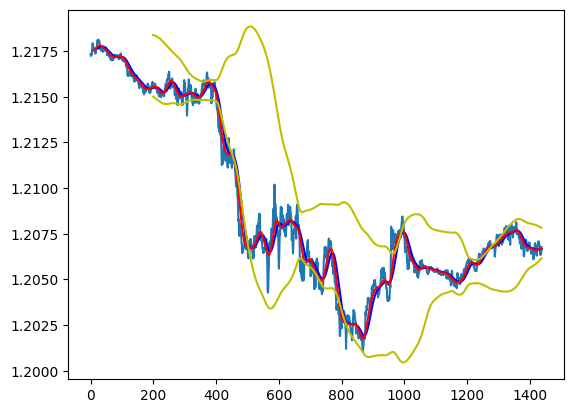

In [71]:
plt.plot(eurusd)
plt.plot(slow_ma, color='b')
plt.plot(fast_ma, color='r')

upper, lower = bollinger_bands(eurusd_trend)
plt.plot(upper, color='y')
plt.plot(lower, color='y')
plt.show()

In [147]:
def backtest(symbol, slow_ma, fast_ma, account_balance=1000, percentage_of_portfolio_at_risk=0.05, risk_tolerance = 0.01):
    
    win_counter = 0
    loss_counter = 0 
    
    #total_losses_allowed = account_balance * percentage_of_portfolio_at_risk
    #at_risk = account_balance * risk_tolerance
    
    
    # Position types are encoded as FREE = 0, LONG = 1, SHORT = -1
    position_type = 0 
    position_price = 0
    loss = 0.00176
    
    #0.000176 := 1
    #0.00020 := x
    
    for t in range(1, len(symbol)):
        
        if position_type == 1:
            if symbol[i] <= position_price - loss:
                #account_balance -= 10
                loss_counter += 1
                position_type = 0
            if (fast_ma[t-1] < slow_ma[t-1]) and (fast_ma[t] > slow_ma[t]):
                print(f'win long diff: {position_price - symbol[t]}')
                #account_balance += 10
                win_counter += 1
                position_type = 0

        elif position_type == -1:
            if symbol[i] >= position_price + loss:
                #account_balance -= 10
                loss_counter += 1
                position_type = 0
                    
            if (fast_ma[t-1] > slow_ma[t-1]) and (fast_ma[t] < slow_ma[t]):
                print(f'win short diff: {symbol[t] - position_price}')
                print(f'time:{t}')
                #account_balance += 10
                win_counter += 1
                position_type = 0  
                
        elif position_type == 0:
            if (fast_ma[t-1] < slow_ma[t-1]) and (fast_ma[t] > slow_ma[t]):
                position_price = symbol[t]
                position_type = -1
                
            elif (fast_ma[t-1] > slow_ma[t-1]) and (fast_ma[t] < slow_ma[t]):
                position_price = symbol[t]
                position_type = 1
                
        
                
    print(f'WINS: {win_counter}')
    print(f'LOSSES: {loss_counter}')
    #print(f'FINAL BALANCE: {account_balance}')

In [148]:
adjusted_eurusd = eurusd[eurusd.size - slow_ma.size:].to_numpy()
adjusted_fast_ma = fast_ma[fast_ma.size - slow_ma.size:].to_numpy()
adjusted_slow_ma = slow_ma.to_numpy()


#contracts1*price1 - contracts2*price2 = 10

#for i in range(len(adjusted_eurusd)):
#    print(adjusted_eurusd[i])

backtest(adjusted_eurusd, adjusted_slow_ma, adjusted_fast_ma)

win long diff: -0.010599999999999943
win short diff: -0.0030399999999999316
time:909
win short diff: -0.0022800000000000598
time:1012
WINS: 3
LOSSES: 1
FINAL BALANCE: 1020


In [187]:
#end_date = datetime.now()
#start_date = end_date - BDay(7)

start_date = '2023-03-01'
end_date = '2023-03-05'

location = "Retail\\Forex\\Major"
forex = get_prices(location)

#eurusd = get_bars(forex[1].name, start_date, end_date)['close']

eurusd = vbt.YFData.download('EURUSD=X', start=start_date, end=end_date, interval='1m').get('Close')
eurusd

Datetime
2023-03-01 00:00:00+00:00    1.057977
2023-03-01 00:01:00+00:00    1.057977
2023-03-01 00:02:00+00:00    1.057641
2023-03-01 00:03:00+00:00    1.057641
2023-03-01 00:04:00+00:00    1.057641
                               ...   
2023-03-03 22:25:00+00:00    1.063490
2023-03-03 22:26:00+00:00    1.063490
2023-03-03 22:27:00+00:00    1.063490
2023-03-03 22:28:00+00:00    1.063490
2023-03-03 22:29:00+00:00    1.063490
Name: Close, Length: 4181, dtype: float64

In [188]:
eurusd_cycle, eurusd_trend = sm.tsa.filters.hpfilter(eurusd)

fast_ma = vbt.MA.run(eurusd_trend, 10, short_name='fast')
slow_ma = vbt.MA.run(eurusd_trend, 20, short_name='slow')



AttributeError: module 'vectorbt' has no attribute 'EMA'

In [189]:
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)

In [190]:
pf = vbt.Portfolio.from_signals(eurusd, entries, exits)

In [191]:
print(pf.stats())

Start                         2023-03-01 00:00:00+00:00
End                           2023-03-03 22:29:00+00:00
Period                                             4181
Start Value                                       100.0
End Value                                    103.020381
Total Return [%]                               3.020381
Benchmark Return [%]                           0.521118
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               0.159604
Max Drawdown Duration                             469.0
Total Trades                                         53
Total Closed Trades                                  53
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  71.698113
Best Trade [%]                                 0.479078
Worst Trade [%]                               -0

C:\Users\TEPJA\AppData\Roaming\Python\Python310\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
C:\Users\TEPJA\AppData\Roaming\Python\Python310\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
C:\Users\TEPJA\AppData\Roaming\Python\Python310\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
C:\Users\TEPJA\AppData\Roaming\Python\Python310\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


In [122]:
def pairs(j):
    return [(x, y) for x in range(1, j) for y in range(x+1, j+1)]


In [144]:
eurusd_cycle, eurusd_trend = sm.tsa.filters.hpfilter(eurusd)

best_pair = ()
best_return = 0

for pair in pairs(200):
    fast_ma = vbt.MA.run(eurusd_trend, pair[0], short_name='fast')
    slow_ma = vbt.MA.run(eurusd_trend, pair[1], short_name='slow')
    
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    
    pf = vbt.Portfolio.from_signals(eurusd, entries, exits)
    print(pf.total_return() * 100 + 100)
    
    if best_return < pf.total_return():
        best_return = pf.total_return()
        best_pair = pair
    #print(pf.stats(settings=dict(freq='s')))
    
print(f'best pair: {best_pair}, best return: {best_return}') 
print(best_return * 100 + 100)

100.78988636623416
100.7616703665733
100.79625010270018
100.82030272596688
100.68875138912807
100.65224837579706
100.71849692464782
100.89913607909841
100.90108000864602
100.93637457804307
100.77209093434114
100.62578926058312
100.6394333297432
100.62617974575325
100.53264672668993
100.50527996368929
100.52446768418639
100.4743848178941
100.32911944004874
100.17181337383425
100.20487547019582
100.27440442232907
100.27901994471722
100.38125293532029
100.48933116407467
100.37947583376427
100.34427099503888
100.23052951763441
100.28940581122272
100.30634196096648
100.26910697917646
100.16205475338549
100.09148673451527
100.18929546494797
100.15025223223368
100.13696419810387
100.11783131597392
100.1203204264511
100.12364226853559
100.12364226853559
100.05809099959559
100.08716316616528
100.13528247124476
100.13528247124476
100.13527982655324
100.11540727923988
100.11540727923988
100.17349541339773
100.17349541339773
100.16435428277697
100.12869448357627
100.12869448357627
100.125371674616